###       Notebook on CHIVI expts !!

In [119]:
import sys, os
sys.path.append('..')
sys.path.append('../..')
import autograd
import pickle
import pystan


In [120]:

import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
#import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       full_rank_gaussian_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_klvi_pd,
                       black_box_klvi_pd2,
                       black_box_chivi,
                       perturbed_black_box_vi,
                       make_stan_log_density,
                       adagrad_optimize, 
                       adagrad_perturb_optimize
                      )
from experiments import (get_samples_and_log_weights, 
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         check_approx_accuracy,
                         print_bounds)

from data_generator import (data_generator_linear)

In [121]:

from viabel.vb import  rmsprop_IA_optimize_with_rhat, adam_IA_optimize_with_rhat

In [58]:

regression_model_code = """data {
  int<lower=0> N;   // number of observations
  int<lower=0> D;   // number of observations
  matrix[N, D] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[D] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  y ~ student_t(40, x * beta, 1);  // likelihood
  #y ~ normal( x * beta, 0.5);  // likelihood
}"""

In [122]:
try:
    sm = pickle.load(open('robust_reg_model_t.pkl', 'rb'))
except:
    sm = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open('robust_reg_model_t.pkl', 'wb') as f:
        pickle.dump(sm, f)



#### the posterior is almost isotropic with very small correlation ...   D=10, N=60

In [123]:
N=80
k=9
SEED= 5080
alpha=1.
noise_sigma=0.5
noise_var = noise_sigma**2
rho = 0.1
regression_data = data_generator_linear(N, k, alpha=alpha,noise_variance=noise_var,rho=rho, seed=SEED)
X = regression_data['X']
Y = regression_data['Y']
Y=Y[:,0]
W = regression_data['W']

In [134]:
os.makedirs('../figures', exist_ok=True)
lims = dict(xlim=[-.9,1.0], ylim=[-0.6,0.8])

In [125]:
#data = dict(N=N, x=x, y=y, D=k)
data = dict(N=N, x=X, y=Y, D=k)
fit = sm.sampling(data=data)

In [126]:

true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)
true_std = np.sqrt(np.diag(true_cov))

In [127]:
print(true_mean)
print(np.log(true_std))


[-0.27450818 -0.24141035 -1.93735056 -1.86213879  0.1496676  -0.41612562
  0.93692184 -0.28217675  2.61779247]
[-2.17068954 -2.11239955 -1.94755029 -2.08507252 -2.06067722 -2.12392362
 -2.14575092 -2.07757629 -1.96918952]


In [128]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
fr_g_var_family = t_variational_family(k, df=1000000)
mf_t_var_family= mean_field_t_variational_family(k, df=40)
stan_log_density = make_stan_log_density(fit)
chivi_mf_objective_and_grad_pd = black_box_chivi(2, mf_g_var_family, stan_log_density, 2000)
chivi_t_mf_objective_and_grad_pd = black_box_chivi(2, mf_t_var_family, stan_log_density, 2000)
chivi_fr_objective_and_grad_pd = black_box_chivi(2, fr_g_var_family, stan_log_density, 2000)

In [129]:
mf_t_var_family = mf_t_var_family = mean_field_t_variational_family(k, 10)
stan_log_density = make_stan_log_density(fit)
klvi_objective_and_grad = black_box_klvi(mf_t_var_family, stan_log_density, 100)

init_mean    = np.zeros(k)
init_log_std = np.ones(k)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000

#plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_var_param, **lims)
klvi_var_param, klvi_param_history, klvi_history, _ = \
    adagrad_optimize(n_iters, klvi_objective_and_grad, init_var_param, learning_rate=.01)

Average Loss = 49.905: 100%|██████████| 5000/5000 [00:41<00:00, 119.37it/s]


In [130]:
print(true_mean)
print(np.log(true_std))
print(klvi_var_param)

[-0.27450818 -0.24141035 -1.93735056 -1.86213879  0.1496676  -0.41612562
  0.93692184 -0.28217675  2.61779247]
[-2.17068954 -2.11239955 -1.94755029 -2.08507252 -2.06067722 -2.12392362
 -2.14575092 -2.07757629 -1.96918952]
[-0.2740304  -0.24171379 -1.93891669 -1.8621061   0.14981623 -0.41626157
  0.9343013  -0.282121    2.61559831 -2.35694486 -2.27365774 -2.12551252
 -2.27860824 -2.24109711 -2.26959971 -2.30178571 -2.26061057 -2.1585468 ]


####  plot the true posterior and apprximate posterior for the first two dimensions
True is in black, and approximate is in red

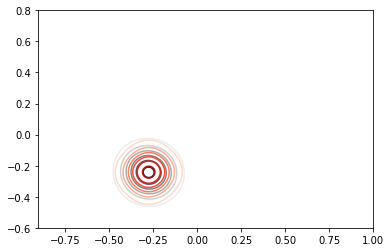

In [135]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, klvi_var_param, **lims,
                               savepath='figures/robust-regression-mf-klvi-good1.pdf', aux_var = true_mean[2:])

#### Let us consider two runs, we will use the KLVI optimised params as the initialisation ....

####  Let us first see a good run (with such good initialisation and  dof = 4) on simple simulated linear regression ....

In [153]:
mf_t_var_family = mean_field_t_variational_family(k, 5)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 500)

init_param1 = klvi_var_param.copy()
print(init_param1.shape)
init_param1[k:] +=1.0

(18,)


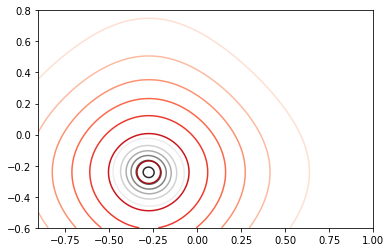

In [154]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, init_param1, **lims,
                               savepath='figures/robust-regression-mf-klvi-good10.pdf', aux_var = true_mean[2:])

In [155]:
a,b,c,d = adagrad_optimize(1200, chivi_objective_and_grad,  init_param1, False, window=10, learning_rate=.01, learning_rate_end=0.004)

Average Loss = -38.465: 100%|██████████| 1200/1200 [01:19<00:00, 15.15it/s]


In [156]:
a1,b1,c1,d1 = adagrad_optimize(400, chivi_objective_and_grad,  a, False, window=10, learning_rate=.008)

Average Loss = -41.214: 100%|██████████| 400/400 [00:26<00:00, 14.97it/s]


[-0.2740304  -0.24171379 -1.93891669 -1.8621061   0.14981623 -0.41626157
  0.9343013  -0.282121    2.61559831 -2.35694486 -2.27365774 -2.12551252
 -2.27860824 -2.24109711 -2.26959971 -2.30178571 -2.26061057 -2.1585468 ]
[-0.25754425 -0.25178905 -1.98209202 -1.79885973  0.21791323 -0.34643301
  0.99977352 -0.24828375  2.63367224 -0.66794908 -0.57126278 -0.44834527
 -0.57585724 -0.55624683 -0.56365533 -0.59316089 -0.56779324 -0.46104765]
[-0.27450818 -0.24141035 -1.93735056 -1.86213879  0.1496676  -0.41612562
  0.93692184 -0.28217675  2.61779247]
[-2.17068954 -2.11239955 -1.94755029 -2.08507252 -2.06067722 -2.12392362
 -2.14575092 -2.07757629 -1.96918952]
-41.236739823716896
-41.657942563646586


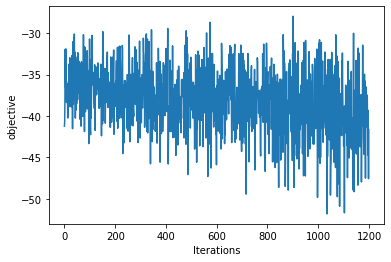

In [157]:
print(klvi_var_param)
print(a)
#print(b[-1])
print(true_mean)
print(np.log(true_std))

plt.plot(c)
plt.ylabel('objective')
plt.xlabel('Iterations')
plt.savefig('good_chivi_run6.pdf')
print(c[0])
print(c[-1])

#### same plot as above with chivi

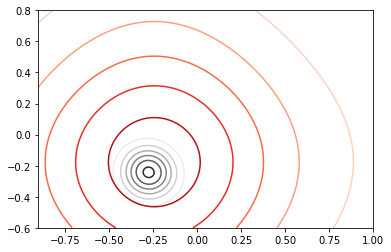

In [158]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, a1, **lims,
                               savepath='figures/robust-regression-mf-chivi-good5.pdf', aux_var = true_mean[2:])

#### Now let us see a bad run , we start with the same location parameters but add a positive value=1.4 to each std dev. parameter.

In [7]:
mf_t_var_family = mean_field_t_variational_family(k, 4.5)
chivi_objective_and_grad = black_box_chivi(2, mf_t_var_family, stan_log_density, 500)

init_param1 = klvi_var_param.copy()
print(init_param1.shape)
### just adding some positive value to initial std dev..
init_param1[k:] += 1.4

NameError: name 'k' is not defined

In [ ]:
a1,b1,c1,d1 = adagrad_optimize(3000, chivi_objective_and_grad,  init_param1, False, window=10, learning_rate=.01)

In [ ]:
plot_approx_and_exact_contours(stan_log_density, mf_t_var_family, a1, **lims,
                               savepath='../figures/robust-regression-mf-chivi-bad.pdf', aux_var = true_mean[2:])

In [8]:
try:
    ncp = pickle.load(open('eight_schools_ncp.pkl', 'rb'))
except:
    ncp = pystan.StanModel(file='eight_schools_ncp.stan', model_name='eight_School_ncp_model')
    with open('eight_schools_ncp.pkl', 'wb') as f:
        pickle.dump(ncp, f)

In [9]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
data = dict(J=J, y=y, sigma=sigma)

In [11]:
eight_schools_ncp_fit = ncp.sampling(data=data, iter=25000, warmup=2000, thin=3,
                                                              control=dict(adapt_delta=.95))

In [12]:
eight_schools_ncp_fit

Inference for Stan model: eight_School_model_83f1609305e7267422b692fbee65a5db.
4 chains, each with iter=25000; warmup=2000; thin=3; 
post-warmup draws per chain=7667, total post-warmup draws=30668.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               4.39    0.02   3.31   -2.2   2.22   4.41   6.63  10.78  31353    1.0
tau              3.59    0.02    3.2   0.12   1.26   2.75   5.02  11.69  29440    1.0
theta_tilde[1]   0.32  5.6e-3   0.99  -1.68  -0.34   0.33   0.98   2.23  31123    1.0
theta_tilde[2]    0.1  5.4e-3   0.94  -1.75  -0.52    0.1   0.73   1.92  30384    1.0
theta_tilde[3]  -0.09  5.5e-3   0.97   -2.0  -0.74  -0.09   0.56    1.8  30591    1.0
theta_tilde[4]   0.06  5.4e-3   0.94   -1.8  -0.57   0.06   0.69   1.89  30453    1.0
theta_tilde[5]  -0.16  5.3e-3   0.93  -1.98  -0.78  -0.17   0.46    1.7  31178    1.0
theta_tilde[6]  -0.08  5.5e-3   0.94  -1.94  -0.71  -0.08   0.55   1.79  29748    1.0
theta_tilde[7]   0.36  5.5e

In [13]:


# number of parameters and parameter names in non-centered model
n_params_ncp = len(eight_schools_ncp_fit.constrained_param_names())
param_names_ncp = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[2:n_params_ncp]
param_names_ncp_transformed = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[n_params_ncp:]

# construct matrix of samples (both original and transformed) from non-centered model 
samples_ncp_df = eight_schools_ncp_fit.to_dataframe(pars=eight_schools_ncp_fit.flatnames)
samples_ncp_df['log_tau'] = np.log(samples_ncp_df['tau'])
samples_ncp = samples_ncp_df.loc[:,param_names_ncp].values.T
samples_ncp_transformed = samples_ncp_df.loc[:,param_names_ncp_transformed].values.T

# use samples from non-centered model for ground true mean and covariance
true_mean_ncp = np.mean(samples_ncp, axis=1)
true_cov_ncp = np.cov(samples_ncp)
true_mean_ncp_tranformed = np.mean(samples_ncp_transformed, axis=1)
true_cov_ncp_tranformed = np.cov(samples_ncp_transformed)

In [14]:
eight_schools_ncp_log_density = make_stan_log_density(eight_schools_ncp_fit)
var_family_ncp = mean_field_t_variational_family(n_params_ncp, 40)

init_param_ncp = np.concatenate([true_mean_ncp_tranformed, .5*np.log(np.diag(true_cov_ncp_tranformed))])

klvi_objective_and_grad_es_ncp  = black_box_klvi(var_family_ncp, eight_schools_ncp_log_density, 100)

In [15]:
esp1, esp2, esp3, esp4 = adagrad_optimize(10000, klvi_objective_and_grad_es_ncp, init_param_ncp, learning_rate=.01)

Average Loss = 6.812: 100%|██████████| 10000/10000 [00:40<00:00, 244.52it/s]


In [17]:
print(esp1)
print(init_param_ncp)

[ 4.53232132  0.80649955  0.28723678  0.09228743 -0.08090047  0.05429255
 -0.16626544 -0.07519331  0.34182698  0.06518806  1.12410115 -0.34786193
 -0.05712969 -0.09387655 -0.05495745 -0.08559599 -0.10924546 -0.08301073
 -0.09364575 -0.04498318]
[4.39074297 0.80142017 6.1922216  4.92567596 3.92154547 4.73103095
 3.61953791 4.00561165 6.29269237 4.85673008 1.19614031 0.15936373
 1.71974182 1.53847122 1.66168963 1.56685908 1.53826768 1.57419134
 1.61939641 1.67077191]


In [18]:
var_family_ncp = mean_field_t_variational_family(n_params_ncp, 40)
init_param_ncp = np.concatenate([true_mean_ncp_tranformed, .5*np.log(np.diag(true_cov_ncp_tranformed))])
klvi_objective_and_grad_chivi  = black_box_chivi(2, var_family_ncp, eight_schools_ncp_log_density, 500)

In [30]:
esp5, esp6, esp7, esp8 = adagrad_optimize(2500, klvi_objective_and_grad_chivi, esp1, learning_rate=.01, learning_rate_end=0.001)

Average Loss = 8.3017: 100%|██████████| 2500/2500 [00:54<00:00, 45.65it/s]


In [38]:
a = esp7[:,None].reshape(50,-1)
print(esp8.shape)
b= np.mean(esp8, axis=0)
print(b)

(10, 250)
[8.27871414 8.30173873 8.43121592 8.38044636 8.62675119 8.21106676
 8.5647827  8.16340023 8.20848997 8.21391979 8.34987653 8.15282991
 8.2215971  8.52324578 8.29841448 8.31839871 8.34929032 8.55153709
 8.30585766 8.45483902 8.3422441  8.2760025  8.25660296 8.22138548
 8.22890326 8.46365104 8.39089165 8.19994945 8.26041412 8.75749395
 8.30007253 8.46512346 8.30945755 8.35388417 8.54781586 8.72530668
 8.18889378 8.2714337  8.46588973 8.2403726  8.49133088 8.32312032
 8.43786506 8.30132804 8.31344933 8.31868648 8.21556591 8.34467909
 8.47556114 8.32798222 8.32148343 8.40361813 8.26273477 8.15119645
 8.23710536 8.27594554 8.5200091  8.27013482 8.26466265 8.3061511
 8.26509596 8.20546348 8.41743867 8.23274853 8.22565258 8.31967625
 8.19683943 8.33288775 8.35947103 8.32697041 8.59964781 8.47053268
 8.5636199  8.42906314 8.46247015 8.25202707 8.27730792 8.34717673
 8.40594366 8.28425163 8.29072019 8.23711697 8.4741179  8.2174243
 8.35172599 9.23065289 8.24105429 8.33630738 8.2800480

[8.25200318 8.34085571 8.42418373 ... 8.22284835 8.19742178 8.20605473]


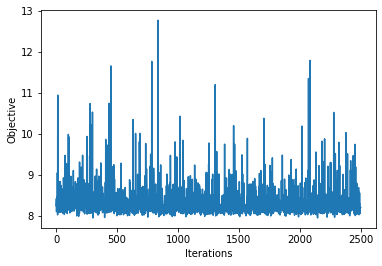

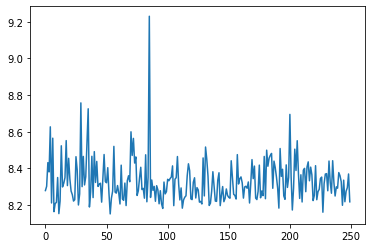

In [39]:
print(esp7)
plt.plot(esp7)
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.savefig('eight_school_good11.pdf')



plt.figure()
plt.plot(b)
plt.savefig('eight_school_good_smooth1.pdf')

In [28]:
esp9, esp10, esp11, esp12 = adagrad_optimize(2500, klvi_objective_and_grad_chivi, init_param_ncp, learning_rate=.01, learning_rate_end =0.001)

Average Loss = -22.308: 100%|██████████| 2500/2500 [00:53<00:00, 46.31it/s]


[8.7236504  8.09216738 8.49306044 ... 8.11188357 8.18579632 8.12186103]


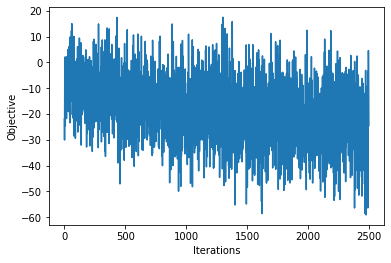

In [29]:
print(esp7)
plt.plot(esp11)
plt.xlabel('Iterations')
plt.ylabel('Objective')
plt.savefig('eight_school_good2.pdf')




In [ ]:
klvi_cp, chivi_cp, klvi_cp_results, chivi_cp_results, other_klvi_cp_results, other_chivi_cp_results = \
    run_experiment(eight_schools_cp_log_density, var_family_cp, init_param_cp, 
                   true_mean_ncp_tranformed, true_cov_ncp_tranformed, 
                   learning_rate=.01, learning_rate_end=.001,
                   n_iters=10000, bound_w2=2500000, verbose=True)